In [30]:
using PhotonPropagation
using PhotonSurrogateModel
using NeutrinoSurrogateModelData
using PhysicsTools
using StaticArrays
using LinearAlgebra
using Random
using Flux
using DataFrames
using CairoMakie
using BSON
using LogExpFunctions
using Distributions

In [7]:
model = BSON.load("/home/wecapstor3/capn/capn100h/simple_mlp_amp_model.bson")[:model]

SimpleMLPAmpModel(Chain(Dense(6 => 512, relu), Dropout(0.1, active=false), Dense(512 => 512, relu), Dropout(0.1, active=false), Dense(512 => 512, relu), Dropout(0.1, active=false), Dense(512 => 16)))

In [22]:
function get_log_amplitudes(particles, targets, model::SimpleMLPAmpModel; feat_buffer, device=gpu)

    n_pmt = get_pmt_count(eltype(targets))

    #TODO: get rid of this
    input_size = size(model.model.layers[1].weight, 2)

    amp_buffer = @view feat_buffer[1:input_size, 1:length(targets)*length(particles)]
    create_model_input!(model, particles, targets, amp_buffer)

    input = amp_buffer
    input = permutedims(input)'

    log_expec_per_src_trg::Matrix{eltype(input)} = cpu(model(device(input)))

    log_expec_per_src_pmt_rs = reshape(
        log_expec_per_src_trg,
        n_pmt, length(particles), length(targets))

    log_expec_per_pmt = LogExpFunctions.logsumexp(log_expec_per_src_pmt_rs, dims=2)

    return log_expec_per_pmt, log_expec_per_src_pmt_rs
end


get_log_amplitudes (generic function with 1 method)

In [29]:
feat_buffer = zeros(Float32, 6, 100)

6×100 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [33]:
dir_ct = 0.2
dir_phis = 0:0.01:2π
target = POM(SA[0., 0., 0.], 1);

amps = []

for dir_phi in dir_phis
    pdir = sph_to_cart(acos(dir_ct), dir_phi)
    particle = Particle(SA[0., 10, 0], pdir, 0., 4E3, 0., PEMinus)
    log_amps = get_log_amplitudes([particle], [target], model, feat_buffer=feat_buffer, device=cpu)
    push!(amps, exp.(log_amps[1]))
end
    

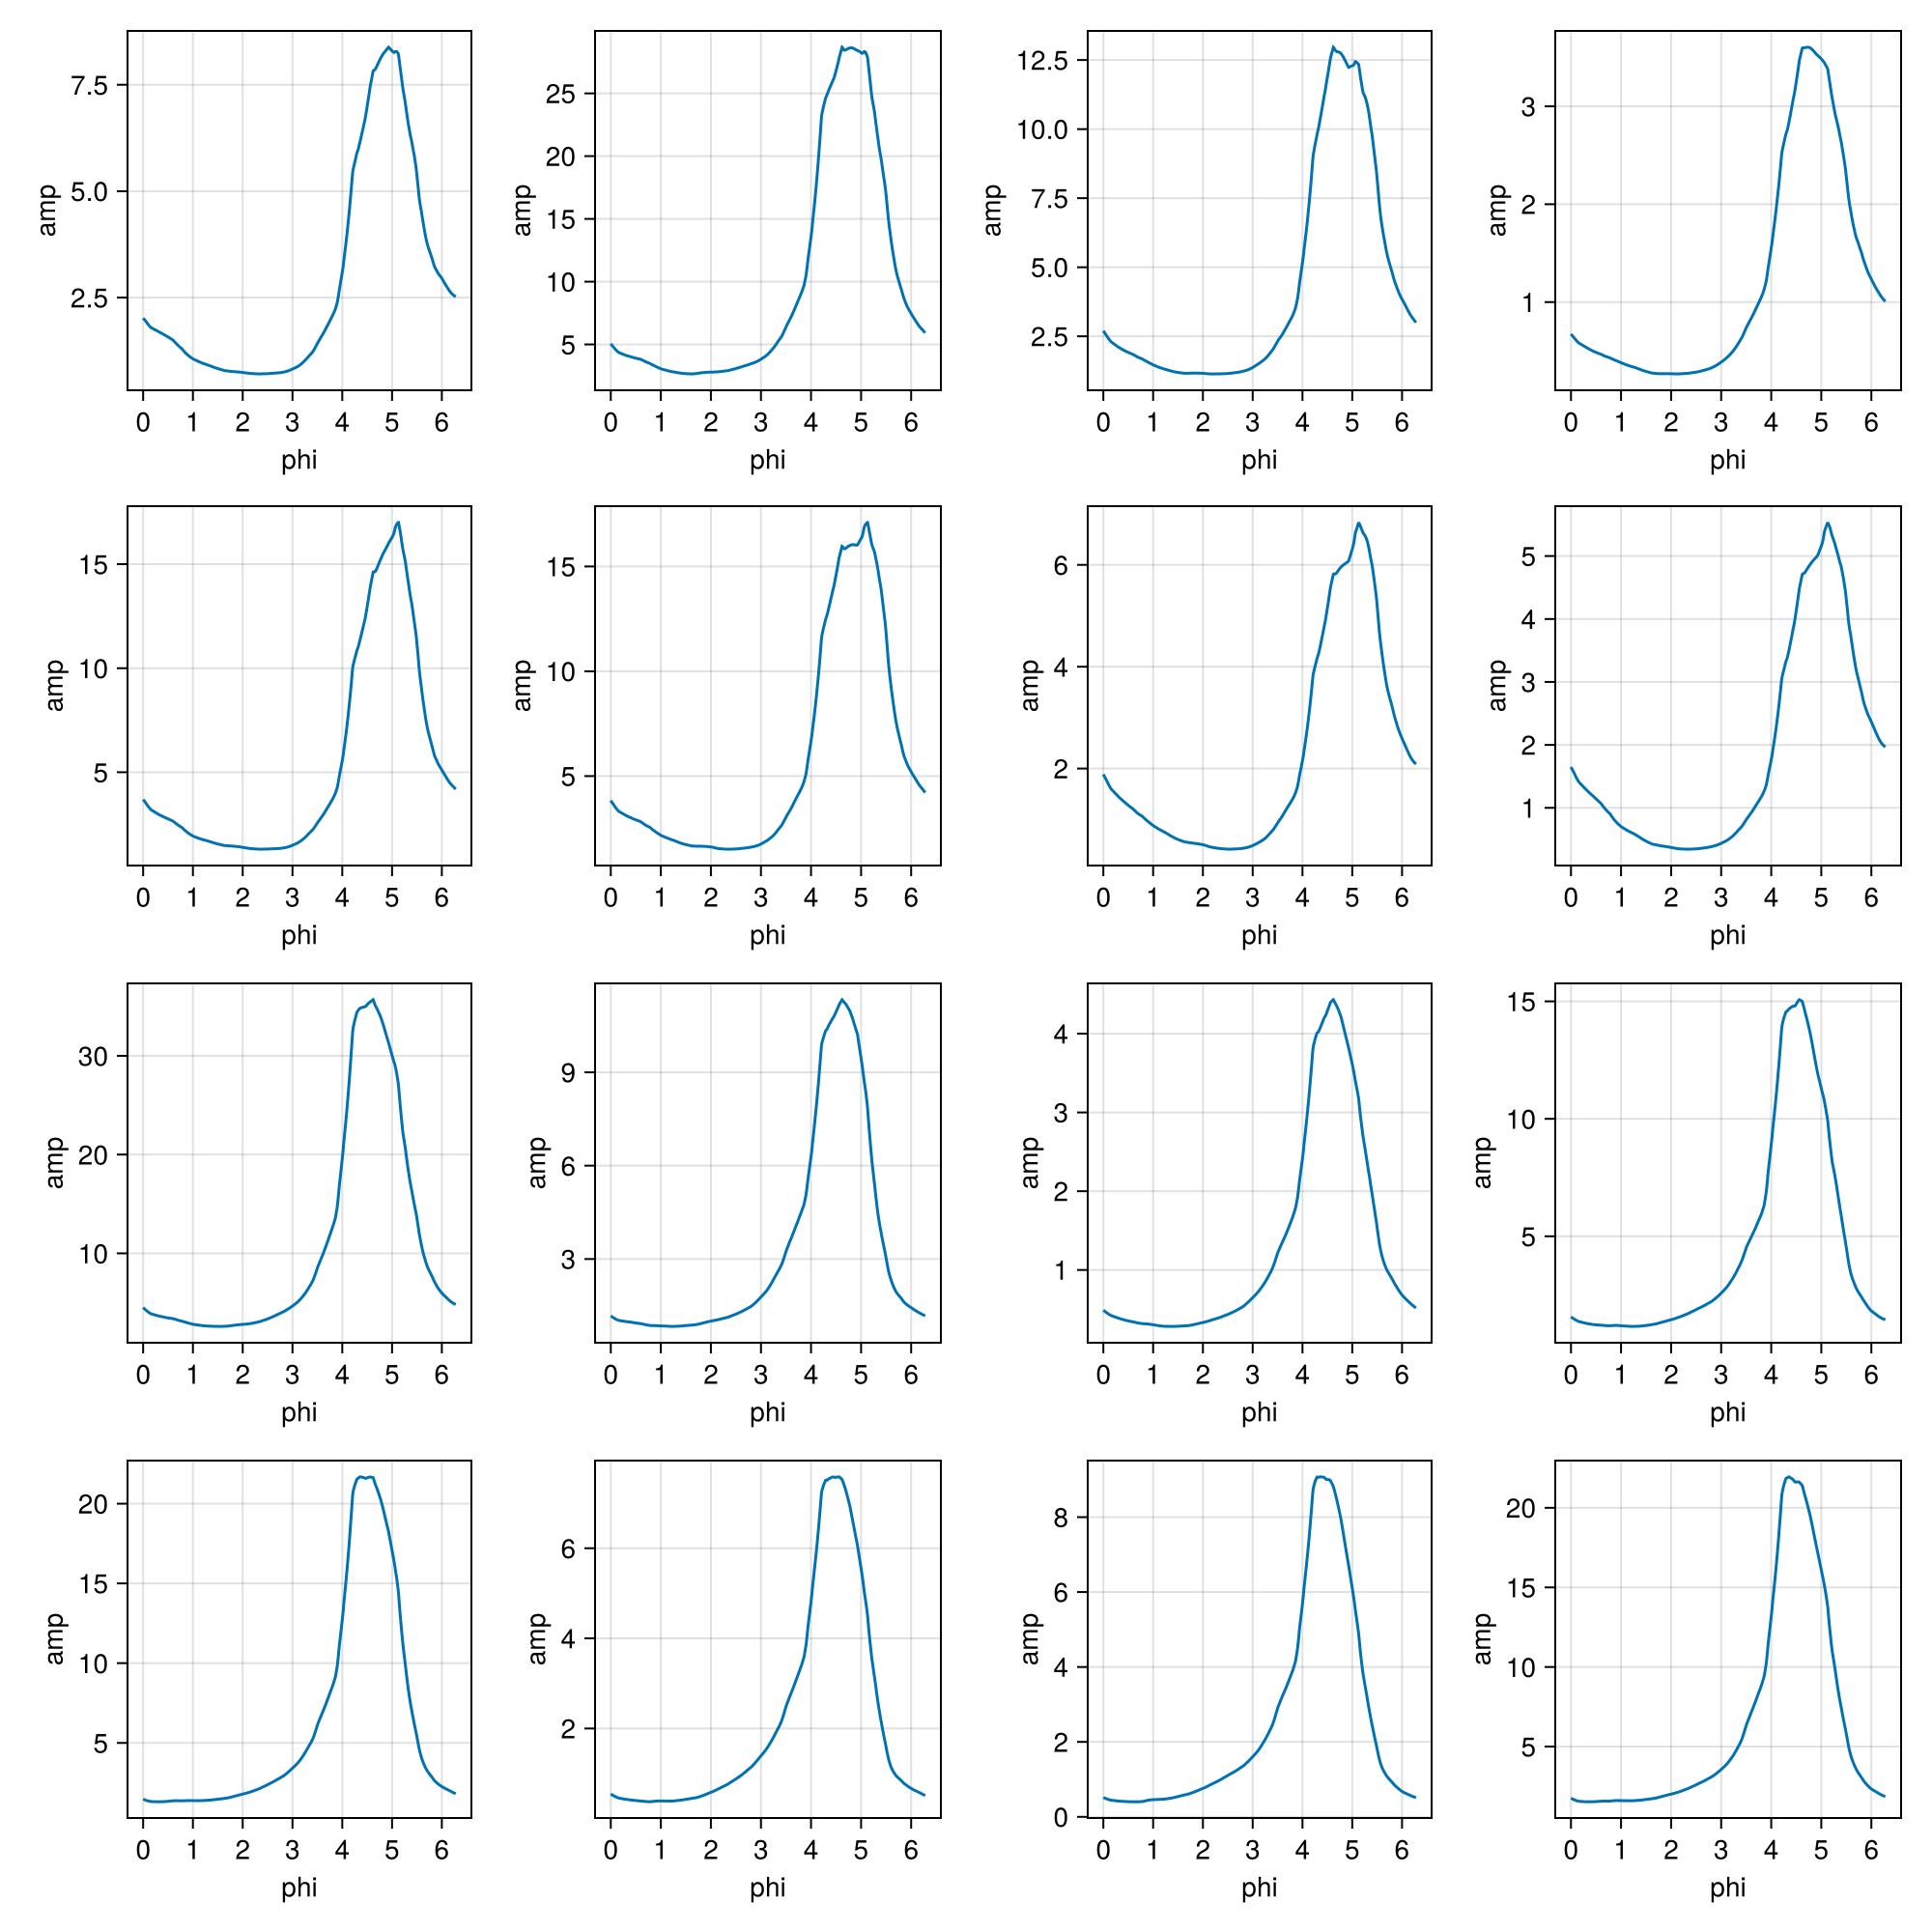

In [35]:
fig = Figure(size=(1000, 1000))
axes = []
for pmt_ix in 1:16
    row, col = divrem(pmt_ix-1, 4)
    ax = Axis(fig[row, col], xlabel="phi", ylabel="amp")
    push!(axes, ax)
end


for pmt_ix in 1:16
    this_amps = [a[pmt_ix] for a in amps]
    lines!(axes[pmt_ix], dir_phis, this_amps)
end
fig




In [28]:
size(log_amps[1])

(16, 1, 1)